In [1]:
%matplotlib notebook
from utils import *
from lossnet import *
from transformer import *
import os
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


<IPython.core.display.Javascript object>


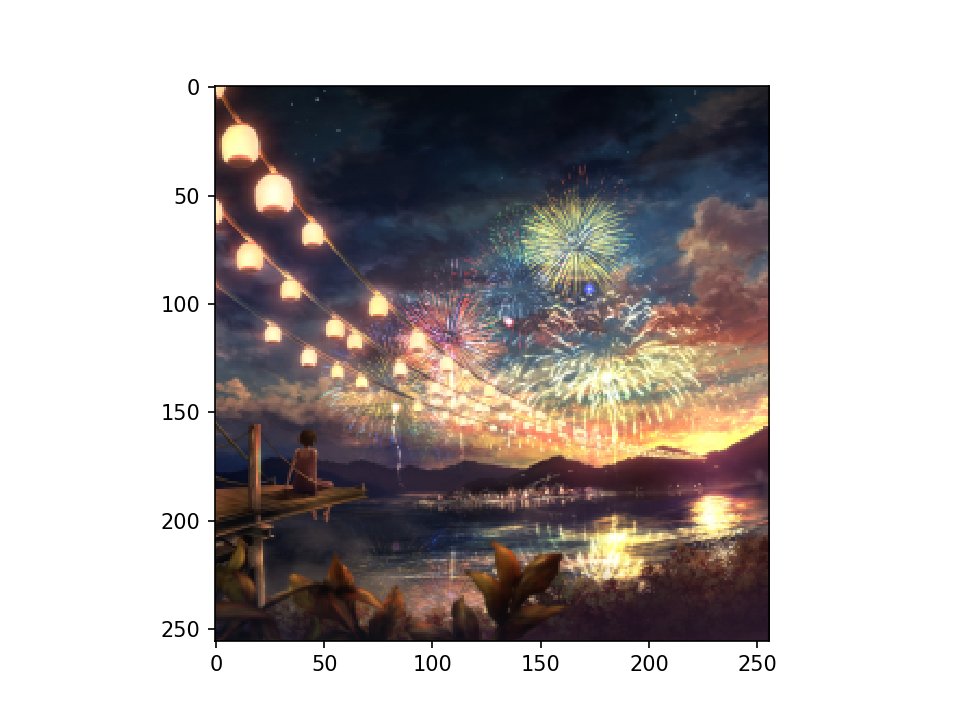

In [3]:
#Sanity check to see if prep_style and imshow display correctly
style_image = prep_style("Style_Images/fireworks.jpg")
plt.figure()
imshow(style_image)

In [4]:
#Load dataset and dataloader. Save to pin memory.
torch.manual_seed(30)
torch.cuda.manual_seed(30)
np.random.seed(30)
dataset_root_dir = '/datasets/COCO-2015'
dataset = Custom_Data_Loader(dataset_root_dir)
train_loader = td.DataLoader(dataset, batch_size=4, shuffle=True, pin_memory=True)

In [3]:
#Load model from a checkpoint if checkpoint exists.
model_path = "Models/fireworks_model.pth.tar"
transformer = TransNet().to(device)
optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-3)
e=0
c=[]
s=[]
t=[]
if os.path.exists(model_path):
    e, c, s, t = load_model(transformer, optimizer, model_path)
else:
    print("Path does not exist. New model initialized.")

In [5]:
def run(trans_net, loss_net, style_img, optimizer, fig, axes, data_loader, num_steps=300,
       style_weight=1, content_weight=0.0001, path="checkpoint.pth.tar",
       content_loss_hist=[], style_loss_hist=[], total_loss_hist=[], run_start=[0]):
    
    run = run_start #run_start is the iteration on which to begin the experiment
    content_loss_history = content_loss_hist
    style_loss_history = style_loss_hist
    total_loss_history = total_loss_hist
    total_loss = 0
    if run[0]>0:
        content_loss_sum = content_loss_history[-1]*run[0]
        style_loss_sum = style_loss_history[-1]*run[0]
        total_loss_sum = total_loss_history[-1]*run[0]
    else:
        content_loss_sum = 0
        style_loss_sum = 0
        total_loss_sum = 0
    
    def vgg_preproc2(img_batch, scale=True):
        mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32).reshape(1,3,1,1).to(device)
        sd = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32).reshape(1,3,1,1).to(device)
        img_batch = img_batch.to(device)
        #Shift range of values from [-1,1] to [0,1]
        if scale is True:
            img_batch = (torch.ones((1,3,1,1), dtype=torch.float32).to(device).add(img_batch)).div_(2)
        img_batch = (img_batch-mean)/sd
        return img_batch
    
    style_img_mean = vgg_preproc2(style_img, scale=False)
    style_features = loss_net(style_img_mean)[1]
    style_gram = []
    for feature_map in style_features:
        style_gram.append(gram_matrix(feature_map))
    
    
    for batch_ndx, batch in enumerate(data_loader):
        if run[0] > num_steps:
            save_model(trans_net, optimizer, run[0], content_loss_history, style_loss_history,
                       total_loss_history, path)
            return run[0], style_loss_history, content_loss_history, total_loss_history
        
        curr_batch_size = batch.shape[0]
        batch = batch.to(device)
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        
        trans_batch0 = trans_net(batch) #pass batch through transformatoin network
        trans_batch = vgg_preproc2(trans_batch0) #preproces batch for loss network
        #get reference content features with original batch
        ref_content_features, ref_style_features = loss_net(vgg_preproc2(batch, scale=False))
        content_features, style_features = loss_net(trans_batch) #get features of transformed batch
        
        #Content loss
        MSELoss = nn.MSELoss().to(device)
        content_loss = content_weight*MSELoss(content_features[0], ref_content_features[0])
        content_loss_sum += content_loss.item()
        
        #Style loss
        style_loss = 0
        for map_index in range(len(style_features)):
            s_loss = MSELoss(gram_matrix(style_features[map_index]), style_gram[map_index])
            style_loss += s_loss
        style_loss = style_loss*style_weight
        style_loss_sum += style_loss.item()
        
        #Total losses
        total_loss = content_loss+style_loss
        total_loss_sum += total_loss.item()
        
        #Backprop
        total_loss.backward()
        optimizer.step()
        
        style_loss_history.append(style_loss_sum/(run[0]+1))
        content_loss_history.append(content_loss_sum/(run[0]+1))
        total_loss_history.append(total_loss_sum/(run[0]+1))
        
        #Plot
        run[0] += 1
        if run[0] % 20 == 0:
            with torch.no_grad():
                out_test = trans_net(batch[0].unsqueeze(0))
                out_test = (torch.ones((1,3,1,1), dtype=torch.float32).to(device).add(out_test)).div_(2)
            plot(fig=fig, axes=axes, style_img=style_img, content_img=batch[0].unsqueeze(0),
                transfer_img=out_test, iteration=run[0],
                content_loss=content_loss_history[20:],
                style_loss=style_loss_history[20:],
                total_loss=total_loss_history[20:])
            print("RUN {}:".format(run))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_loss.item(), content_loss.item()))
        
        #Save model and track stats
        if run[0] % 500 == 0:
            save_model(trans_net, optimizer, run[0], content_loss_history, style_loss_history,
                      total_loss_history, path)

<IPython.core.display.Javascript object>


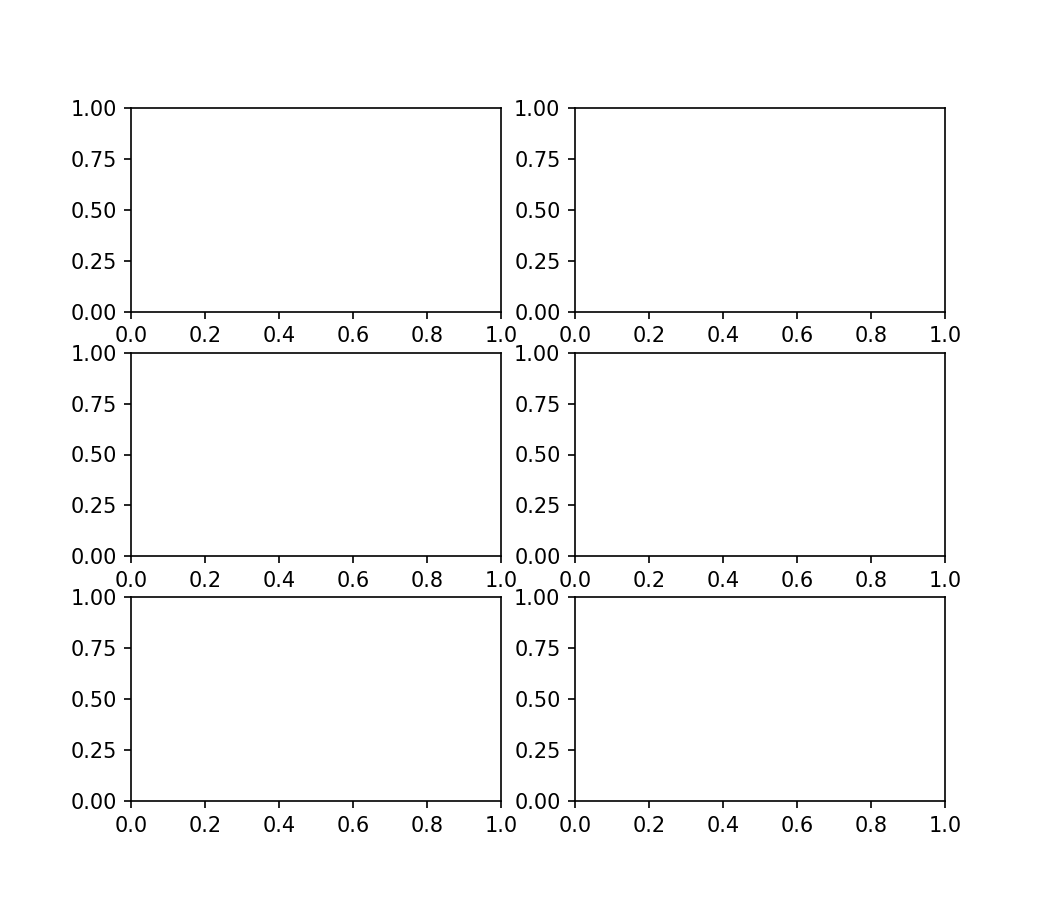

In [9]:
#Set checkpoint path and run
checkpoint_model_path = "Models/fireworks_model_test.pth.tar"
style_image = prep_style("Style_Images/fireworks.jpg")
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(7,6))
vgg = LossNet().to(device)
epoch, style, content, total = run(transformer, vgg, style_image, optimizer, fig, axes, train_loader, num_steps=20680,
   style_weight=10, content_weight=0.001, path=checkpoint_model_path,
    content_loss_hist=c,style_loss_hist=s, total_loss_hist=t, run_start=[e])

<IPython.core.display.Javascript object>


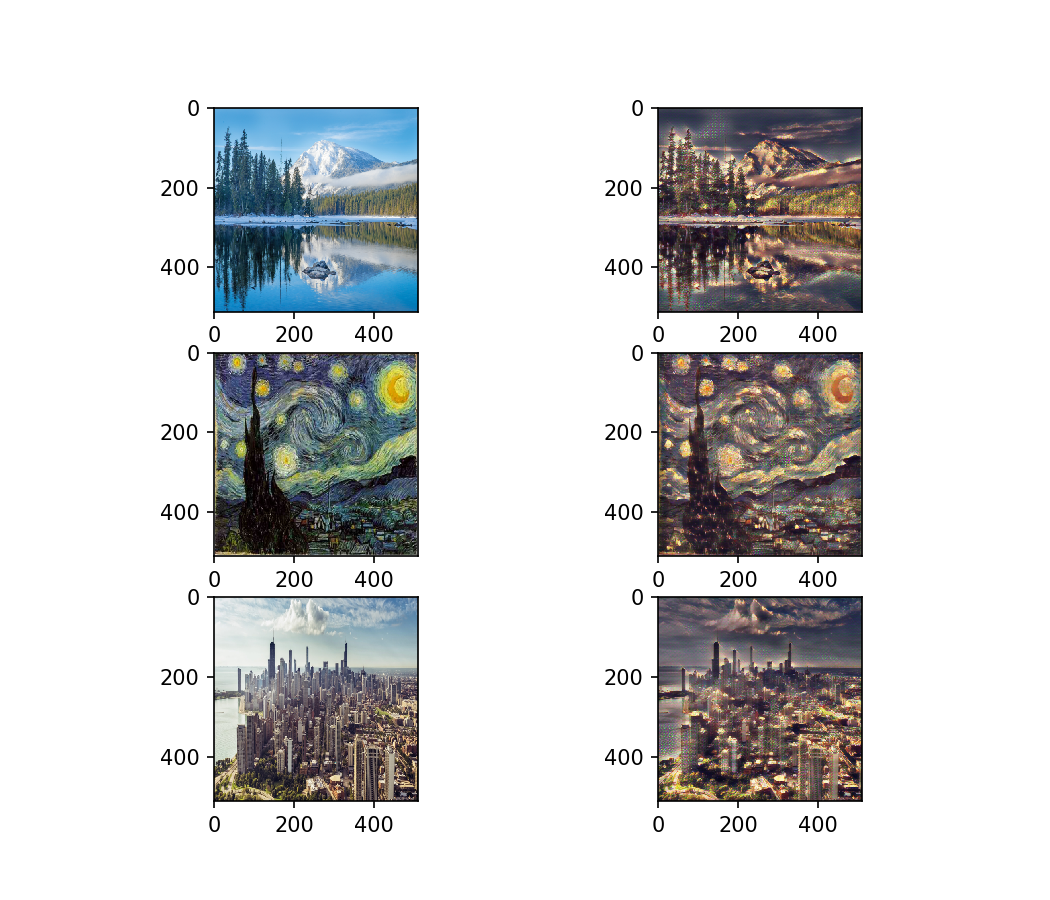

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(7,6))
test_img1 = prep_style("Test_Images/mountain.jpg",(512,512))
test_img2 = prep_style("Style_Images/starrynight.jpg",(512,512))
test_img3 = prep_style("Test_Images/chicago.jpg",(512,512))
with torch.no_grad():
    out_img1 = transformer(test_img1)
    out_img2 = transformer(test_img2)
    out_img3 = transformer(test_img3)
out_img1 = (torch.ones((1,3,1,1), dtype=torch.float32).to(device).add(out_img1)).div_(2)
out_img2 = (torch.ones((1,3,1,1), dtype=torch.float32).to(device).add(out_img2)).div_(2)
out_img3 = (torch.ones((1,3,1,1), dtype=torch.float32).to(device).add(out_img3)).div_(2)

#save_image(out_img1, "Images/test1.jpg")
#save_image(out_img2, "Images/test2.jpg")
#save_image(out_img3, "Images/test3.jpg")

imshow(test_img1, ax=axes[0][0])
imshow(test_img2, ax=axes[1][0])
imshow(test_img3, ax=axes[2][0])
imshow(out_img1, ax=axes[0][1])
imshow(out_img2, ax=axes[1][1])
imshow(out_img3, ax=axes[2][1])